In [ ]:
!pip uninstall -y jax jaxlib flax numpy pandas transformers accelerate peft sentence-transformers faiss-cpu

Found existing installation: jax 0.7.2
Uninstalling jax-0.7.2:
  Successfully uninstalled jax-0.7.2
Found existing installation: jaxlib 0.7.2
Uninstalling jaxlib-0.7.2:
  Successfully uninstalled jaxlib-0.7.2
Found existing installation: flax 0.10.7
Uninstalling flax-0.10.7:
  Successfully uninstalled flax-0.10.7
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: transformers 4.40.2
Uninstalling transformers-4.40.2:
  Successfully uninstalled transformers-4.40.2
Found existing installation: accelerate 0.30.1
Uninstalling accelerate-0.30.1:
  Successfully uninstalled accelerate-0.30.1
Found existing installation: peft 0.10.0
Uninstalling peft-0.10.0:
  Successfully uninstalled peft-0.10.0
Found existing installation: sentence-transformers 5.2.0
Uninstalling sentence-transformers-5.2.0:
  Succes

In [ ]:
!pip install numpy==1.26.4 pandas==2.2.2

In [ ]:
!pip install torch==2.2.2

In [ ]:
!pip install transformers==4.40.2 accelerate==0.30.1 peft==0.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 114.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.3
    Uninstalling transformers-4.57.3:
      Successfully uninstalled transformers-4.57.3
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.12.0
    Uninstalling accelerate-1.12.0:
      Successfully uninstalled accelerate-1.12.0
  Attempting uninstall: peft
    Found existing installation: peft 0.18.0
    Uni

In [ ]:
import torch
import transformers
import accelerate
import peft

print("torch:", torch.__version__)
print("transformers:", transformers.__version__)
print("accelerate:", accelerate.__version__)
print("peft:", peft.__version__)

from google.colab import drive
drive.mount("/content/drive")

import os, re, unicodedata, pickle
import pandas as pd
import numpy as np

BASE_DIR = "/content/drive/MyDrive/İlaç"

PATH_SECONDARY = os.path.join(BASE_DIR, "secondary_ddi_clean_v1.csv")
PATH_ADR       = os.path.join(BASE_DIR, "clean_adr_v1.csv")
PATH_FDA_DDI   = os.path.join(BASE_DIR, "clean_fda_ddi.csv")          # kanıt için (opsiyonel)
PATH_DAILYMED  = os.path.join(BASE_DIR, "dailymed_db_final.pkl")      # hazır parse edilmiş
PATH_CON=os.path.join(BASE_DIR, "canonical_fda_v1.csv" )
df_canonical=pd.read_csv(PATH_CON)
print("Paths OK")
df_fda_ddi = pd.read_csv(PATH_FDA_DDI)
df_secondary_ddi = pd.read_csv(PATH_SECONDARY)
df_dailymed = pd.read_csv(
    PATH_DAILYMED,
    encoding="latin-1",
    on_bad_lines="skip",
    low_memory=False
)


print("Paths OK")


FORMULATION_WORDS = {w.lower() for w in {
    "mg","mcg","ug","g","kg","ml","l","iu","unit","units","percent","%","tablet","tablets","tab","tabs",
    "capsule","capsules","cap","caps","solution","solutions","syrup","suspension","emulsion","drops","spray",
    "extended","release","extended-release","controlled-release","cr","sr","xr","xl","er","dr",
    "delayed","enteric","oral","iv","im","sc","sublingual","rectal","vaginal","intranasal",
    "hydrochloride","hcl","sodium","potassium","chloride","acetate","phosphate","nitrate","sulfate","succinate",
    "fumarate","tartrate","mesylate","maleate","bromide","monohydrate","dihydrate","anhydrous",
    "injection","vial","ampule","prefilled","patch",
    "usp","bp","ip","rx","otc","strength","dose","dosage","daily","weekly","monthly"
}}

def normalize_drug_name(name: str) -> str:
    if not isinstance(name, str): return ""
    s = name.lower().replace("®"," ").replace("™"," ")
    s = re.sub(r"[\(\)\[\]\{\},;:/\\\-\+]", " ", s)
    s = re.sub(r"\d+(\.\d+)?", " ", s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"[^a-z\s]", " ", s)
    s = name.lower()

    toks = []
    for t in s.split():
        if t in FORMULATION_WORDS:
            continue
        if len(t) <= 1:
            continue
        toks.append(t)
    return " ".join(toks).strip()

def make_pair_key(a: str, b: str) -> str:
    if not a or not b: return None
    x, y = sorted([a, b])
    return f"{x} || {y}"

df_drug_info = pd.read_csv("/content/drive/MyDrive/İlaç/drug_usage_final1.csv")

df_drug_info["drug_norm"] = df_drug_info["drug_name"].map(normalize_drug_name)

drug_info_map = (
    df_drug_info
    .groupby("drug_norm", as_index=True)
    .agg({
        "drug_name": "first",
        "usage_final": "first"
    })
)

print("Usage entries:", drug_info_map.shape)

df_fda_ddi["pair_key"] = df_fda_ddi.apply(
    lambda r: make_pair_key(r["drugA_norm"], r["drugB_norm"]),
    axis=1
)

df_secondary = pd.read_csv(PATH_SECONDARY)
df_adr       = pd.read_csv(PATH_ADR)


df_fda = None
if os.path.exists(PATH_FDA_DDI):
    df_fda = pd.read_csv(PATH_FDA_DDI)

print("secondary:", df_secondary.shape)
print("adr:", df_adr.shape)
print("fda:", None if df_fda is None else df_fda.shape)


# drugA_norm/drugB_norm yoksa üret
for col_raw, col_norm in [("drugA", "drugA_norm"), ("drugB", "drugB_norm")]:
    if col_norm not in df_secondary.columns:
        if col_raw in df_secondary.columns:
            df_secondary[col_norm] = df_secondary[col_raw].astype(str).map(normalize_drug_name)
        else:
            raise ValueError(f"secondary içinde {col_norm} veya {col_raw} yok.")

df_secondary["pair_key"] = df_secondary.apply(lambda r: make_pair_key(r["drugA_norm"], r["drugB_norm"]), axis=1)

# karar kolonu bul
candidate_cols = ["decision_4class", "final_decision", "mapped_severity", "decision"]
decision_col = next((c for c in candidate_cols if c in df_secondary.columns), None)
if decision_col is None:
    raise ValueError("secondary içinde karar kolonu bulunamadı (decision_4class/final_decision/mapped_severity/decision).")

print("Decision col:", decision_col)
print(df_secondary[decision_col].value_counts().head(10))


def decision4_to_action3(x: str) -> str:
    if not isinstance(x, str): return "no_interaction"
    s = x.strip().lower()
    if "avoid" in s or "contra" in s:
        return "avoid"
    if "dose" in s or "adjust" in s:
        return "monitor"         # 3-class’ta dose_adjust -> monitor
    if "monitor" in s or "caution" in s:
        return "monitor"
    if "no" in s or "none" in s:
        return "no_interaction"
    return "monitor"  # bilinmeyenleri konservatif monitor

df_secondary["action_3class"] = df_secondary[decision_col].map(decision4_to_action3)
print(df_secondary["action_3class"].value_counts())

with open(PATH_DAILYMED, "rb") as f:
    df_dailymed = pickle.load(f)

print("DailyMed drugs:", len(df_dailymed))

# drug_norm yoksa üret
if "drug_norm" not in df_adr.columns:
    name_col = "drug_name" if "drug_name" in df_adr.columns else None
    if name_col is None:
        raise ValueError("ADR içinde drug_norm veya drug_name yok.")
    df_adr["drug_norm"] = df_adr[name_col].astype(str).map(normalize_drug_name)

if "risk_score" not in df_adr.columns:
    raise ValueError("ADR içinde risk_score yok.")
df_adr["risk_score"] = pd.to_numeric(df_adr["risk_score"], errors="coerce").fillna(0).clip(0,3)

adr_risk_map = df_adr.groupby("drug_norm")["risk_score"].max().astype(int).to_dict()

def adr_risk_for(drug_norm: str) -> int:
    if not isinstance(drug_norm, str): return 0
    return int(adr_risk_map.get(drug_norm.strip(), 0))


rag_records = []

# FDA cümleleri (opsiyonel)
if df_fda is not None and "sentence" in df_fda.columns:
    if "drugA_norm" not in df_fda.columns and "drugA" in df_fda.columns:
        df_fda["drugA_norm"] = df_fda["drugA"].astype(str).map(normalize_drug_name)
    if "drugB_norm" not in df_fda.columns and "drugB" in df_fda.columns:
        df_fda["drugB_norm"] = df_fda["drugB"].astype(str).map(normalize_drug_name)

    for i, r in df_fda.iterrows():
        sent = str(r.get("sentence") or "").strip()
        if not sent:
            continue
        rag_records.append({
            "id": f"fda_{i}",
            "source": "FDA_SENTENCE",
            "drugA_norm": r.get("drugA_norm"),
            "drugB_norm": r.get("drugB_norm"),
            "text": sent
        })

# DailyMed bölümleri
for drug_norm, prof in df_dailymed.items():
    for sec in ["contraindications","interactions","warnings"]:
        txt = str(prof.get(sec) or "").strip()
        if not txt:
            continue
        paras = [p.strip() for p in txt.split("\n\n---\n\n") if p.strip()]
        for j, p in enumerate(paras):
            rag_records.append({
                "id": f"dm_{drug_norm}_{sec}_{j}",
                "source": f"DAILYMED_{sec.upper()}",
                "drugA_norm": drug_norm,
                "drugB_norm": None,
                "text": p
            })

rag_df = pd.DataFrame(rag_records)
print("RAG docs:", len(rag_df))
rag_df.head()


# secondary'den pozitif örnekler (monitor/avoid)
df_pos = df_secondary[df_secondary["action_3class"].isin(["monitor","avoid"])][["drugA_norm","drugB_norm","pair_key","action_3class"]].dropna().drop_duplicates()

# negatif üretim: random drug havuzundan "hiçbir kaynakta görünmeyen" çiftler seç
all_drugs = sorted(set(df_secondary["drugA_norm"].dropna().tolist() + df_secondary["drugB_norm"].dropna().tolist()))
pos_keys = set(df_pos["pair_key"].tolist())

def generate_no_interaction_pairs(n=3000, max_tries=200000):
    rng = np.random.default_rng(42)
    out = []
    tries = 0
    out_keys = set()

    while len(out) < n and tries < max_tries:
        tries += 1
        a = all_drugs[int(rng.integers(0, len(all_drugs)))]
        b = all_drugs[int(rng.integers(0, len(all_drugs)))]
        if a == b:
            continue
        key = make_pair_key(a, b)
        if key in pos_keys or key in out_keys:
            continue

        # DailyMed: ikisinde de kontra/interaction metni olabilir; bu “no_interaction” seçmeyi zorlaştırır.
        # Burada basit filtre: eğer iki ilacın da DailyMed profili hiç yoksa yine kabul edebiliriz.
        # (İstersen daha katı yaparız: profili olanlarda interaction kelimesi taraması gibi.)
        out.append({"drugA_norm": a, "drugB_norm": b, "pair_key": key, "action_3class": "no_interaction"})
        out_keys.add(key)

    return pd.DataFrame(out)

df_no = generate_no_interaction_pairs(3000)
print("no_interaction:", df_no.shape)

df_model = pd.concat([df_pos, df_no], ignore_index=True).drop_duplicates("pair_key")
print(df_model["action_3class"].value_counts())


# 🔴 TEXT KOLONUNU GARANTİ ALTINA AL
df_model = df_model.copy()

df_model["text"] = (
    "Interaction between " +
    df_model["drugA_norm"].astype(str) +
    " and " +
    df_model["drugB_norm"].astype(str)
)

# Label zaten vardı ama garanti edelim
label_names = ["no_interaction", "monitor", "avoid"]
label2id = {n: i for i, n in enumerate(label_names)}
df_model["label"] = df_model["action_3class"].map(label2id)

# Kontrol
print(df_model[["text", "action_3class", "label"]].head())
print(df_model["action_3class"].value_counts())

MODEL_PATH = "/content/drive/MyDrive/İlaç/content/biobert_ddi_3class_secondary2"

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_model = AutoTokenizer.from_pretrained(MODEL_PATH)
model_ddi = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

model_ddi.to(device)
model_ddi.eval()

print("✅ Model başarıyla yüklendi:", MODEL_PATH)


# 3 sınıf aksiyonlar: no_interaction / monitor / avoid

ACTION3_ORDER = {"no_interaction": 0, "monitor": 1, "avoid": 2}

def decision4_to_action3(x: str):
    if not isinstance(x, str):
        return None
    s = x.strip().lower()

    # olası varyasyonlar
    if s in ["no_interaction", "none", "no interaction", "no-interaction"]:
        return "no_interaction"
    if s in ["monitor", "caution", "use with caution"]:
        return "monitor"
    if s in ["dose_adjust", "dose adjustment", "adjust dose", "dosage adjustment"]:
        return "monitor"          # 3 sınıfta monitor'a düşürüyoruz
    if s in ["avoid", "avoid_combination", "avoid combination", "contraindicated", "do not use"]:
        return "avoid"

    # mapped_severity içinde geçiyorsa yakala
    if "avoid" in s or "contra" in s:
        return "avoid"
    if "dose" in s or "monitor" in s or "caution" in s:
        return "monitor"

    return None


def stronger_action(a, b):
    """İki action_3class'tan daha şiddetlisini döndür."""
    if a is None: return b
    if b is None: return a
    return a if ACTION3_ORDER[a] >= ACTION3_ORDER[b] else b


# ===============================
# SECONDARY MATCH (CURATED DDI)
# ===============================

def secondary_match_for_pair(drugA_norm: str, drugB_norm: str):
    """
    Finds interaction from secondary curated DDI dataset.
    Returns the strongest interaction record or None.
    """

    if not isinstance(drugA_norm, str) or not isinstance(drugB_norm, str):
        return None

    key = make_pair_key(drugA_norm, drugB_norm)
    if key is None:
        return None

    if "pair_key" not in df_secondary.columns:
        raise ValueError("df_secondary must contain 'pair_key' column")

    subset = df_secondary[df_secondary["pair_key"] == key]
    if subset.empty:
        return None

    df = subset.copy()

    # ---------------------------
    # Determine decision column
    # ---------------------------
    decision_col = None
    for c in ["decision_4class", "final_decision", "mapped_severity", "decision"]:
        if c in df.columns:
            decision_col = c
            break

    if decision_col is None:
        # fallback: return first row, undecided
        row = df.iloc[0].to_dict()
        row["_action_3class"] = None
        return row

    # ---------------------------
    # Map to 3-class action
    # ---------------------------
    df["_action_3class"] = (
        df[decision_col]
        .astype(str)
        .apply(decision4_to_action3)
    )

    # ---------------------------
    # Rank by severity
    # ---------------------------
    ACTION_RANK = {
        "no_interaction": 0,
        "monitor": 1,
        "avoid": 2
    }

    df["_rank"] = df["_action_3class"].map(
        lambda x: ACTION_RANK.get(x, 0)
    )

    # If confidence exists, use it as tie-breaker
    if "confidence" in df.columns:
        df["_conf"] = (
            pd.to_numeric(df["confidence"], errors="coerce")
            .fillna(0.0)
        )
    else:
        df["_conf"] = 0.0

    # ---------------------------
    # Select strongest record
    # ---------------------------
    best = (
        df
        .sort_values(
            by=["_rank", "_conf"],
            ascending=False
        )
        .iloc[0]
        .to_dict()
    )

    return best

def derive_risk_level(action, reasons):
    if action == "avoid":
        return "high"
    if any("bleeding" in r for r in reasons):
        return "high"
    if any("cyp" in r.lower() for r in reasons):
        return "moderate"
    return "low"


# ===============================
# FDA-SPECIFIC ACTION LOGIC
# ===============================

def fda_sentence_to_action3(sentence: str) -> str:
    """
    FDA label sentences are evidence, NOT decisions.
    However, severe harm language escalates to AVOID.
    """
    if not isinstance(sentence, str):
        return "monitor"

    s = sentence.lower()

    # 🔴 EXPLICIT CONTRAINDICATION
    if any(k in s for k in [
        "contraindicated",
        "do not use",
        "should not be used",
        "avoid concomitant use"
    ]):
        return "avoid"

    # 🔴 SEVERE / LIFE-THREATENING RISK
    if any(k in s for k in [
        "major or fatal",
        "life-threatening",
        "serious bleeding",
        "significant bleeding",
        "black box warning",
        "fatal bleeding",
        "severe hemorrhage"
    ]):
        return "avoid"

    # 🟡 CLINICAL RISK → MONITOR
    if any(k in s for k in [
        "increase",
        "may increase",
        "increases",
        "decrease clearance",
        "plasma concentration",
        "bleeding risk",
        "qt prolongation"
    ]):
        return "monitor"

    return "monitor"


def fda_match_for_pair(drugA_norm: str, drugB_norm: str):
    """
    FDA match WITHOUT decision4_to_action3.
    Action is derived ONLY from label sentence content.
    """
    key = make_pair_key(drugA_norm, drugB_norm)
    if key is None or "pair_key" not in df_fda_ddi.columns:
        return None

    subset = df_fda_ddi[df_fda_ddi["pair_key"] == key]
    if subset.empty:
        return None

    # Pick the most informative row (confidence is secondary)
    row = subset.sort_values(
        "confidence",
        ascending=False
    ).iloc[0].to_dict()

    sentence = row.get("sentence", "")
    action = fda_sentence_to_action3(sentence)

    row["_action_3class"] = action
    return row


# ===============================
# INTERACTION ANALYSIS (ENGLISH)
# ===============================

def analyze_interaction_en(drugA: str, drugB: str):
    a = normalize_drug_name(drugA)
    b = normalize_drug_name(drugB)

    # 1️⃣ FDA (highest priority)
    fda = fda_match_for_pair(a, b)
    if fda:
        reasons = extract_interaction_reason(fda.get("sentence", ""))

        action = fda.get("_action_3class", "monitor")
        risk_level =derive_risk_level(action,reasons)

        return {
            "type": "interaction",
            "drug_pair": [a, b],
            "risk_level": risk_level,
            "summary_en": (
                "This drug combination poses a significant clinical risk."
                if action == "avoid"
                else "This drug combination requires clinical caution."
            ),
            "details_en": [
                r["effect"].capitalize()
                if isinstance(r, dict) else str(r)
                for r in reasons
            ],
            "source": "FDA"
        }

    # 2️⃣ Secondary (curated decisions)
    sec = secondary_match_for_pair(a, b)
    if sec:
        action = sec.get("_action_3class", "monitor")

        return {
            "type": "interaction",
            "drug_pair": [a, b],
            "risk_level": "high" if action == "avoid" else "moderate",
            "summary_en": "This drug combination requires clinical caution.",
            "details_en": [
                "Interaction reported in secondary clinical sources."
            ],
            "source": "Secondary"
        }

    # 3️⃣ DailyMed signal
    dm = dailymed_signal_for_pair(a, b)
    if dm and dm.get("action_3class"):
        return {
            "type": "interaction",
            "drug_pair": [a, b],
            "risk_level": "moderate",
            "summary_en": "Potential interaction noted in product labeling.",
            "details_en": [
                "Interaction warning mentioned in DailyMed labeling."
            ],
            "source": "DailyMed"
        }

    # 4️⃣ Model (last resort)
    model = model_predict_action3(a, b)
    if model.get("action_3class") != "no_interaction":
        return {
            "type": "interaction",
            "drug_pair": [a, b],
            "risk_level": "uncertain",
            "summary_en": "A potential interaction was predicted by the model.",
            "details_en": [
                "Prediction based on learned interaction patterns."
            ],
            "source": "Model"
        }

    # 5️⃣ No interaction
    return {
        "type": "interaction",
        "drug_pair": [a, b],
        "risk_level": "low",
        "summary_en": "No clinically significant interaction was identified.",
        "details_en": [],
        "source": "None"
    }
    return {
     "type": "no_interaction",
     "drug_pair": [a, b],
     "risk_level": "low",
     "summary_en": "No clinically significant interaction was identified.",
     "details_en": [],
     "source": "None"
}


# Eski fonksiyonun adaptörü (wrapper)

def fda_match_for_pair(drugA_norm: str, drugB_norm: str):
    return fda_best_match_for_pair(drugA_norm, drugB_norm)

def dailymed_profile_for(drug_norm: str):
    if not isinstance(drug_norm, str) or not drug_norm:
        return None
    return df_dailymed.get(drug_norm)


# DailyMed metninden "açık risk" sinyali çıkar (modeli susturacak)
SEVERE_DM_PATTERNS = [
    r"\bcontraindicat",          # contraindicated
    r"\bdo not use\b",
    r"\bavoid concomitant\b",
    r"\bfatal\b",
    r"\blife[- ]threat",         # life-threatening
    r"\bserious adverse\b",
]

MONITOR_DM_PATTERNS = [
    r"\buse with caution\b",
    r"\bcaution\b",
    r"\bmonitor\b",
    r"\bmay increase\b",
    r"\brisk of\b",
]

def dailymed_signal_for_pair(drugA_norm: str, drugB_norm: str):
    """
    Çift için: A'nın ve B'nin DailyMed metinlerinde diğer ilacın geçmesi + pattern.
    Çıktı: {"action_3class": ..., "evidence": [...]} veya None
    """
    profA = dailymed_profile_for(drugA_norm)
    profB = dailymed_profile_for(drugB_norm)
    if not profA and not profB:
        return None

    def scan(profile, other_norm):
        if not profile:
            return []
        chunks = []
        for k in ["contraindications", "warnings", "interactions"]:
            t = str(profile.get(k) or "")
            if not t:
                continue
            # diğer ilaç adı metinde geçsin (kabaca)
            if other_norm in t.lower():
                chunks.append((k, t))
        return chunks

    evid = []
    # A metninde B
    for sec, txt in scan(profA, drugB_norm):
        evid.append({"who": "drugA", "section": sec, "text": txt[:1200]})
    # B metninde A
    for sec, txt in scan(profB, drugA_norm):
        evid.append({"who": "drugB", "section": sec, "text": txt[:1200]})

    if not evid:
        return None

    joined = " ".join(e["text"].lower() for e in evid)

    # Severe önce
    for pat in SEVERE_DM_PATTERNS:
        if re.search(pat, joined, flags=re.IGNORECASE):
            return {"action_3class": "avoid", "evidence": evid, "why": f"DailyMed severe pattern: {pat}"}

    # Monitor
    for pat in MONITOR_DM_PATTERNS:
        if re.search(pat, joined, flags=re.IGNORECASE):
            return {"action_3class": "monitor", "evidence": evid, "why": f"DailyMed monitor pattern: {pat}"}

    # Metin var ama pattern yok → belirsiz
    return {"action_3class": None, "evidence": evid, "why": "DailyMed mentions exist but no clear pattern."}


def model_predict_action3(drugA_norm: str, drugB_norm: str):
    text = f"Interaction between {drugA_norm} and {drugB_norm}"

    inputs = tokenizer_model(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model_ddi(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()

    labels = ["no_interaction", "monitor", "avoid"]
    probs_dict = {labels[i]: float(probs[i]) for i in range(len(labels))}

    action = max(probs_dict, key=probs_dict.get)

    return {
        "action_3class": action,
        "probs": probs_dict
    }


def _interaction_summary_en(action: str) -> str:
    if action == "avoid":
        return "This drug combination poses a significant clinical risk."
    if action == "monitor":
        return "This drug combination may be used with close clinical monitoring."
    return "No clinically significant interaction was identified."


#ingilizce
def summarize_usage_en(raw_text: str):
    if not isinstance(raw_text, str) or len(raw_text.strip()) < 50:
        return None

    text = raw_text.lower()

    indications = []
    admin_notes = []

    # Basit ama etkili klinik sinyaller
    if "respiratory tract" in text:
        indications.append("Respiratory tract infections")
    if "meningitis" in text:
        indications.append("Bacterial meningitis")
    if "septicemia" in text:
        indications.append("Septicemia")
    if "endocarditis" in text:
        indications.append("Endocarditis")
    if "urinary tract" in text:
        indications.append("Urinary tract infections")
    if "gastrointestinal" in text or "salmonella" in text or "shigella" in text:
        indications.append("Gastrointestinal infections")

    if "intravenous" in text or "parenteral" in text:
        admin_notes.append("May be administered intravenously for severe infections")
    if "oral" in text:
        admin_notes.append("Oral administration may be used when appropriate")
    if "culture" in text or "susceptibility" in text:
        admin_notes.append("Therapy should be guided by culture and susceptibility testing")

    return {
        "summary_en": "Ampicillin is an antibiotic used to treat a broad range of bacterial infections.",
        "indications_en": sorted(set(indications)),
        "administration_notes_en": sorted(set(admin_notes))
    }

def analyze_usage_en(drug_norm: str) -> dict:
    """
    Extract structured usage information for a drug.
    """

    if drug_norm not in drug_info_map.index:
        return {
            "type": "usage",
            "drug": drug_norm,
            "indications_en": [],
            "administration_notes_en": [],
            "source": "DailyMed"
        }

    raw_text = drug_info_map.loc[drug_norm]["usage_final"]

    indications = []
    administration = []

    text = raw_text.lower()

    # Çok basit ama güvenli heuristik
    if "infection" in text:
        indications.append("bacterial infections")
    if "meningitis" in text:
        indications.append("bacterial meningitis")
    if "endocarditis" in text:
        indications.append("endocarditis")
    if "urinary" in text:
        indications.append("urinary tract infections")
    if "respiratory" in text:
        indications.append("respiratory tract infections")

    if "intravenous" in text or "iv" in text:
        administration.append("intravenous administration may be required for severe infections")
    if "oral" in text:
        administration.append("oral administration may be used when appropriate")

    return {
        "type": "usage",
        "drug": drug_norm,
        "indications_en": list(dict.fromkeys(indications)),
        "administration_notes_en": list(dict.fromkeys(administration)),
        "source": "DailyMed"
    }


def analyze_side_effects_en(drug_norm: str) -> dict:
    """
    Extract structured side effect information using ADR + DailyMed.
    No hallucination, no translation, no inference beyond data.
    """

    # ---- ADR ----
    adr_score = adr_risk_for(drug_norm)

    if adr_score >= 3:
        risk_level = "high"
    elif adr_score == 2:
        risk_level = "moderate"
    elif adr_score == 1:
        risk_level = "low"
    else:
        risk_level = "unknown"

    # ---- DailyMed ----
    dm_profile = dailymed_profile_for(drug_norm)

    key_risks = []
    clinical_notes = []

    if dm_profile:
        warnings = (dm_profile.get("warnings") or "").lower()
        contraindications = (dm_profile.get("contraindications") or "").lower()

        if "bleed" in warnings or "hemorrhag" in warnings:
            key_risks.append("Major or fatal bleeding")

        if "necrosis" in warnings or "gangrene" in warnings:
            key_risks.append("Tissue necrosis and gangrene (rare)")

        if "pregnan" in contraindications:
            key_risks.append("Severe fetal harm during pregnancy")

        if "monitor" in warnings or "inr" in warnings:
            clinical_notes.append("Frequent INR monitoring is required")

        if "elderly" in warnings or "age" in warnings:
            clinical_notes.append("Higher risk in elderly patients")

    if not key_risks:
        key_risks.append("No specific severe adverse effects identified in structured sources")

    if not clinical_notes:
        clinical_notes.append("Careful clinical monitoring is recommended")

    return {
        "type": "side_effect",
        "drug": drug_norm,
        "risk_level": risk_level,
        "key_risks_en": key_risks,
        "clinical_notes_en": clinical_notes,
        "source": "ADR + DailyMed"
    }



def analyze(drugA_raw: str, drugB_raw: str):
    drugA_norm = normalize_drug_name(drugA_raw)
    drugB_norm = normalize_drug_name(drugB_raw)

    sources = {
        "FDA": None,
        "Secondary": None,
        "DailyMed": None,
        "ADR": None,
        "Model": None,
    }
    reasoning = []

    # ADR risk (her zaman ek bilgi)
    adrA = adr_risk_for(drugA_norm)
    adrB = adr_risk_for(drugB_norm)
    sources["ADR"] = {"drugA_risk_score": adrA, "drugB_risk_score": adrB}

    # 1) FDA
    # 1) FDA
    fda = fda_match_for_pair(drugA_norm, drugB_norm)
    if fda is not None:
      fda_action = decision4_to_action3(
        fda.get("mapped_severity")
        or fda.get("final_decision")
        or fda.get("severity_5class")
        or ""
      )

      if fda_action not in ["avoid", "monitor", "no_interaction"]:
        fda_action = "monitor"

      sources["FDA"] = {
        "source": "FDA_LABEL",
        "reason": extract_interaction_reason(
            fda.get("sentence") or ""
        )
      }

      reasoning.append(
        f"FDA kaynağına göre etkileşim tespit edildi: {sources['FDA']['reason']}."
      )

      return _format_result(
        drugA_raw, drugB_raw,
        drugA_norm, drugB_norm,
        fda_action,
        sources,
        reasoning
      )


    # 2) Secondary
    sec = secondary_match_for_pair(drugA_norm, drugB_norm)
    if sec is not None:
        sources["Secondary"] = sec
        sec_action = sec.get("_action_3class")
        if sec_action in ["avoid", "monitor", "no_interaction"]:
            reasoning.append(f"Secondary bulundu → karar Secondary'ye göre: {sec_action} (model susturuldu).")
            final_action = sec_action
            return _format_result(drugA_raw, drugB_raw, drugA_norm, drugB_norm, final_action, sources, reasoning)

    # 3) DailyMed sinyali
    dm = dailymed_signal_for_pair(drugA_norm, drugB_norm)
    if dm is not None:
        sources["DailyMed"] = dm
        dm_action = dm.get("action_3class")
        if dm_action in ["avoid", "monitor"]:
            reasoning.append(f"DailyMed açık sinyal → karar DailyMed'e göre: {dm_action} (model susturuldu).")
            final_action = dm_action
            return _format_result(drugA_raw, drugB_raw, drugA_norm, drugB_norm, final_action, sources, reasoning)
        else:
            reasoning.append("DailyMed mention var ama açık sinyal yok → model konuşabilir.")

    # 4) MODEL (son çare)
    model = model_predict_action3(drugA_norm, drugB_norm)
    sources["Model"] = model

    model_action = model.get("action_3class")
    probs = model.get("probs", {})
    p = float(probs.get(model_action, 0.0))

    # eşikler (senin dediğin mantık)
    if model_action == "avoid" and p >= 0.70:
        final_action = "avoid"
        reasoning.append(f"Kaynak yok → model avoid dedi (p={p:.2f})")
    elif model_action == "monitor" and p >= 0.60:
        final_action = "monitor"
        reasoning.append(f"Kaynak yok → model monitor dedi (p={p:.2f})")
    else:
        final_action = "no_interaction"
        reasoning.append(f"Kaynak yok → model kararsız/ düşük güven (action={model_action}, p={p:.2f}) → no_interaction")

    return _format_result(drugA_raw, drugB_raw, drugA_norm, drugB_norm, final_action, sources, reasoning)


def _format_result(drugA_raw, drugB_raw, drugA_norm, drugB_norm, final_action, sources, reasoning):
    reason_text = None

    if sources.get("FDA"):
        reason_text = sources["FDA"].get("reason")
        source_label = "FDA"

    elif sources.get("DailyMed"):
        reason_text = sources["DailyMed"].get("why")
        source_label = "DailyMed"

    else:
        source_label = "Model"

    if final_action == "avoid":
        msg = (
            f"Bu iki ilacın birlikte kullanımında ciddi risk vardır."
            + (f" Nedeni: {reason_text}." if reason_text else "")
            + f" (Kaynak: {source_label})"
        )

    elif final_action == "monitor":
        msg = (
            f"Bu iki ilacın birlikte kullanımı doktor takibi ile mümkündür."
            + (f" Nedeni: {reason_text}." if reason_text else "")
            + f" (Kaynak: {source_label})"
        )

    else:
        msg = "Bu iki ilaç arasında belirgin bir etkileşim saptanmadı."

    return {
        "final_action_3class": final_action,
        "final_message_tr": msg,
        "input": {"drugA_raw": drugA_raw, "drugB_raw": drugB_raw},
        "normalized": {"drugA_norm": drugA_norm, "drugB_norm": drugB_norm},
        "sources": sources,
        "reasoning": reasoning
    }


def interpret_adr_risk(score: int):
    if score >= 3:
        return "Yüksek"
    if score == 2:
        return "Orta"
    if score == 1:
        return "Düşük"
    return "Belirgin değil"


def analyze_single_drug(drug_raw: str):
    drug_norm = normalize_drug_name(drug_raw)

    # 1️⃣ ADR → risk seviyesi
    adr_score = adr_risk_for(drug_norm)

    if adr_score >= 3:
        risk_level = "high"
        summary = "This medication is associated with a high risk of serious adverse effects."
    elif adr_score == 2:
        risk_level = "moderate"
        summary = "This medication is associated with a moderate risk of adverse effects."
    elif adr_score == 1:
        risk_level = "low"
        summary = "This medication has a relatively low risk of adverse effects."
    else:
        risk_level = "unknown"
        summary = "No significant adverse effect risk has been reported for this medication."

    # 2️⃣ DailyMed → açıklayıcı maddeler
    details = []
    dm_profile = dailymed_profile_for(drug_norm)

    if dm_profile:
        warnings = (dm_profile.get("warnings") or "").lower()

        if "bleed" in warnings or "hemorrhag" in warnings:
            details.append("Major or fatal bleeding events have been reported.")

        if "pregnan" in warnings:
            details.append("Use during pregnancy may cause serious harm.")

        if "monitor" in warnings:
            details.append("Careful clinical monitoring is required during therapy.")

        if not details:
            details.append("Clinically relevant warnings have been reported in official labeling.")

    else:
        details.append("No detailed safety warnings were found in DailyMed.")

    return {
        "type": "side_effect",
        "drug": drug_norm,
        "risk_level": risk_level,
        "summary_en": summary,
        "details_en": details,
        "source": "DailyMed + ADR"
    }


def fda_best_match_for_pair(drugA_norm: str, drugB_norm: str):
    """
    FDA DDI datasetinde sırasız (unordered) eşleşme arar.
    En güçlü satırı dict olarak döner.
    """
    if not isinstance(drugA_norm, str) or not isinstance(drugB_norm, str):
        return None

    key = make_pair_key(drugA_norm, drugB_norm)
    if key is None:
        return None

    if "pair_key" not in df_fda_ddi.columns:
        return None

    subset = df_fda_ddi[df_fda_ddi["pair_key"] == key]
    if subset.empty:
        return None

    # Güven varsa en yüksek confidence
    if "confidence" in subset.columns:
        row = subset.sort_values("confidence", ascending=False).iloc[0]
    else:
        row = subset.iloc[0]

    return row.to_dict()

def fda_match_for_pair(drugA_norm: str, drugB_norm: str):
    return fda_best_match_for_pair(drugA_norm, drugB_norm)


TR_STOP = {
    "ve", "ile", "mi", "mı", "mu", "mü",
    "alınır", "alınırmı", "alınır mı",
    "kullanılır", "kullanılır mı",
    "birlikte", "aynı", "anda",
    "nasıl", "ne", "nedir", "için",
    "mi?", "mı?", "mu?", "mü?",
    "icin","için","ile","ve","mi","mı","mu","mü",
    "ne","nedir","nasıl","kullanılır","kullanimi",
    "yan","etki","etkileri","birlikte"
}


def clean_extracted_drugs(drugs):
    cleaned = []
    for d in drugs:
        d_norm = normalize_drug_name(d)
        if not d_norm:
            continue
        if d_norm in TR_STOP:
            continue
        cleaned.append(d_norm)
    return cleaned


# ===============================
# MASTER DRUG VOCABULARY
# ===============================

ALL_KNOWN_DRUGS = set()

# FDA + Secondary (etkileşim)
ALL_KNOWN_DRUGS |= set(df_fda_ddi["drugA_norm"].dropna())
ALL_KNOWN_DRUGS |= set(df_fda_ddi["drugB_norm"].dropna())

# ADR (yan etki)
ALL_KNOWN_DRUGS |= set(df_adr["drug_norm"].dropna())

# DailyMed (kullanım, uyarı)
ALL_KNOWN_DRUGS |= set(df_dailymed.keys())

# Drug usage csv (kullanım)
ALL_KNOWN_DRUGS |= set(drug_info_map.index)

print("Toplam bilinen ilaç:", len(ALL_KNOWN_DRUGS))



KNOWN_FOR_USAGE = {
    d for d in drug_info_map.index
    if isinstance(d, str) and len(d.strip()) > 2
}


KNOWN_FOR_INTERACTION = set(
    df_fda_ddi["drugA_norm"].dropna().unique()
).union(
    df_fda_ddi["drugB_norm"].dropna().unique()
).union(
    set(df_adr["drug_norm"].dropna().unique())
).union(
    set(df_dailymed.keys())
)

print("usage:", len(KNOWN_FOR_USAGE))
print("interaction:", len(KNOWN_FOR_INTERACTION))


def _extract_sections(root, section_titles):
    """
    SPL XML içinden belirli başlıkları (örn. DOSAGE AND ADMINISTRATION)
    bularak metnini çıkarır.
    """
    texts = []

    for section in root.findall(".//section"):
        title_el = section.find("title")
        if title_el is None:
            continue

        title_text = "".join(title_el.itertext()).strip().upper()

        for wanted in section_titles:
            if wanted.upper() in title_text:
                # section içindeki tüm text'i al
                body_text = " ".join(
                    t.strip() for t in section.itertext() if t.strip()
                )
                texts.append(body_text)

    if not texts:
        return None

    return "\n\n".join(texts)

def normalize_question(q: str) -> str:
    q = q.lower()
    q = re.sub(r"[^\w\sçğıöşü]", " ", q)  # | / + , vs
    q = re.sub(r"\s+", " ", q)
    return q.strip()

def is_valid_drug_name(name: str) -> bool:
    if not isinstance(name, str):
        return False

    if len(name.split()) > 4:
        return False

    blacklist = [
        "deodorant", "cream", "lotion", "shampoo",
        "antiperspirant", "cosmetic"
    ]

    return not any(b in name for b in blacklist)

import torch.nn.functional as F

ID2LABEL_3CLASS = {
    0: "no_interaction",
    1: "monitor",
    2: "avoid"
}

def model_predict_action3(drugA_norm: str, drugB_norm: str):
    """
    BioBERT 3-class modeli.
    SADECE FDA / Secondary / DailyMed sessizse kullanılmalı.
    """

    # Güvenlik
    if not drugA_norm or not drugB_norm:
        return {
            "action_3class": "no_interaction",
            "probs": {
                "no_interaction": 0.33,
                "monitor": 0.33,
                "avoid": 0.33
            }
        }

    text = f"Interaction between {drugA_norm} and {drugB_norm}"

    inputs = tokenizer_model(
        text,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model_ddi(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1).cpu().numpy()[0]

    pred_id = int(probs.argmax())
    action = ID2LABEL_3CLASS[pred_id]

    return {
        "action_3class": action,
        "probs": {
            ID2LABEL_3CLASS[i]: float(probs[i]) for i in range(len(probs))
        }
    }


EN_STOP = {
    "of", "the", "and", "or", "to", "for", "with", "without",
    "are", "is", "was", "were", "be", "been",
    "what", "which", "who", "whom", "this", "that",
    "side", "effects", "effect", "use", "used", "using",
    "can", "could", "should", "may", "might"
}


def extract_drugs_en(question: str):
    words = re.findall(r"[a-zA-Z]+", question.lower())
    candidates = set()

    # 1️⃣ BIGRAMS (öncelik)
    for i in range(len(words) - 1):
        w1, w2 = words[i], words[i + 1]

        if w1 in EN_STOP or w2 in EN_STOP:
            continue

        cand = normalize_drug_name(w1 + " " + w2)

        if (
            cand
            and len(cand) >= 3
            and cand not in EN_STOP
            and cand in ALL_KNOWN_DRUGS
        ):
            candidates.add(cand)

    # 2️⃣ UNIGRAMS
    for w in words:
        if w in EN_STOP:
            continue

        cand = normalize_drug_name(w)

        if (
            cand
            and len(cand) >= 3
            and cand not in EN_STOP
            and cand in ALL_KNOWN_DRUGS
        ):
            candidates.add(cand)

    return list(candidates)

def extract_drugs_from_question(question: str):
    words = re.findall(r"[a-zA-ZçğıöşüÇĞİÖŞÜ]+", question.lower())
    candidates = set()

    # 1️⃣ İkili kelimeler
    for i in range(len(words) - 1):
        w1, w2 = words[i], words[i+1]

        # ❌ stop-word kontrolü
        if w1 in TR_STOP or w2 in TR_STOP:
            continue

        cand = normalize_drug_name(w1 + " " + w2)
        if cand and cand not in TR_STOP:
            candidates.add(cand)

    # 2️⃣ Tekli kelimeler
    for w in words:
        if w in TR_STOP:
            continue

        cand = normalize_drug_name(w)
        if cand and cand not in TR_STOP:
            candidates.add(cand)

    return list(candidates)


INTERACTION_REASON_PATTERNS = [
    {
        "pattern": r"bleed|bleeding|hemorrhag",
        "mechanism": "pharmacodynamic",
        "effect": "increased bleeding risk",
        "severity_hint": "high"
    },
    {
        "pattern": r"cyp\d",
        "mechanism": "pharmacokinetic",
        "effect": "altered drug metabolism via CYP enzymes",
        "severity_hint": "moderate"
    },
    {
        "pattern": r"serotonin",
        "mechanism": "pharmacodynamic",
        "effect": "serotonin syndrome risk",
        "severity_hint": "high"
    },
    {
        "pattern": r"renal|kidney",
        "mechanism": "pharmacodynamic",
        "effect": "renal function impairment risk",
        "severity_hint": "moderate"
    }
]



def extract_interaction_reason(text: str):
    if not isinstance(text, str) or not text.strip():
        return []

    t = text.lower()
    reasons = []

    for rule in INTERACTION_REASON_PATTERNS:
        if re.search(rule["pattern"], t):
            reasons.append(rule["effect"])

    if not reasons:
        reasons.append("clinically significant pharmacological interaction")

    return list(set(reasons))


import pickle

with open("/content/drive/MyDrive/İlaç/dailymed_db_final.pkl", "rb") as f:
  df_dailymed = pickle.load(f)

# rastgele 1 ilaç
drug, content = next(iter(df_dailymed.items()))

drug, content.keys()


#ingilizce
def detect_intent_en(question: str) -> str:
    q = question.lower()

    if any(k in q for k in [
        "side effect", "adverse", "risk", "toxicity"
    ]):
        return "side_effect"

    if any(k in q for k in [
        "how to use", "dosage", "dose", "administered", "administration"
    ]):
        return "usage"

    if any(k in q for k in [
        "interaction", "together", "with", "co-administered", "combined"
    ]):
        return "interaction"

    return "unknown"


def detect_intent(question: str) -> str:
    q = question.lower()

    # 1️⃣ Kullanım / doz ÖNCELİKLİ
    if any(k in q for k in [
        "nasıl kullanılır", "kullanımı", "dozu", "doz", "kaç mg"
    ]):
        return "usage"

    # 2️⃣ Endikasyon
    if any(k in q for k in [
        "ne için", "hangi hastalık", "endikasyon"
    ]):
        return "usage"

    # 3️⃣ Yan etki
    if any(k in q for k in [
        "yan etki", "zarar", "risk"
    ]):
        return "side_effect"

    # 4️⃣ Etkileşim EN SON
    if any(k in q for k in [
        "ile", "birlikte", "aynı anda", "etkileş"
    ]):
        return "interaction"

    return "unknown"

!pip install unidecode


import re
import pandas as pd

path = "/content/drive/MyDrive/İlaç/drug_info_clean.csv"

records = []

with open(path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if not line.startswith('"'):
            continue

        # İlk tırnak içini al
        m = re.match(r'^"([^"]+)"\s*,?\s*(.*)', line)
        if not m:
            continue

        raw = m.group(1)
        rest = m.group(2)

        # drug_name = ilk virgüle kadar
        if "," in raw:
            drug_name = raw.split(",")[0].strip()
            text = raw[len(drug_name):].strip(", ") + " " + rest
        else:
            drug_name = raw.strip()
            text = rest

        records.append({
            "drug_name": drug_name,
            "text": text.strip()
        })

df_drug_info = pd.DataFrame(records)

import re
import unicodedata

def normalize_question(q: str) -> str:
    if not isinstance(q, str):
        return ""

    q = q.lower()

    # Türkçe karakterleri sadeleştir (opsiyonel ama faydalı)
    q = unicodedata.normalize("NFKD", q)
    q = "".join(ch for ch in q if not unicodedata.combining(ch))

    # Noktalama → boşluk
    q = re.sub(r"[^\w\s]", " ", q)

    # Çoklu boşlukları tek yap
    q = re.sub(r"\s+", " ", q).strip()

    return q


#ingilizce
def render_side_effects_en(result: dict) -> str:
    """
    Convert structured side effect data into a clear clinical paragraph.
    """

    drug = result.get("drug", "This medication")
    risk = result.get("risk_level", "unknown")
    risks = result.get("key_risks_en", [])
    notes = result.get("clinical_notes_en", [])
    source = result.get("source", "DailyMed")

    text = (
        f"{drug.capitalize()} is associated with a {risk} risk of adverse effects."
    )

    if risks:
        text += " The most significant concerns include "
        text += ", ".join(r.lower() for r in risks[:3]) + "."

    if notes:
        text += " Clinically, "
        text += "; ".join(n.lower() for n in notes[:2]) + "."

    text += (
        " Patients should be managed based on individual risk factors and clinical judgment."
    )

    text += f" Source: {source}."

    return text


def analyze_side_effects_en(drug_raw: str):
    """
    Analyze adverse effects of a single drug using ADR + DailyMed.
    Returns structured clinical data (NO rendering).
    """

    drug_norm = normalize_drug_name(drug_raw)

    # ---------- ADR RISK ----------
    adr_score = adr_risk_for(drug_norm)

    if adr_score >= 3:
        risk_level = "high"
    elif adr_score == 2:
        risk_level = "moderate"
    elif adr_score == 1:
        risk_level = "low"
    else:
        risk_level = "unknown"

    # ---------- DAILYMED ----------
    dm_profile = dailymed_profile_for(drug_norm)

    warnings = ""
    contraindications = ""

    key_risks = []

    if isinstance(dm_profile, dict):
        warnings = (dm_profile.get("warnings") or "").strip()
        contraindications = (dm_profile.get("contraindications") or "").strip()

        text_blob = f"{warnings} {contraindications}".lower()

        if re.search(r"bleed|bleeding|hemorrhag", text_blob):
            key_risks.append("Major or fatal bleeding events")

        if re.search(r"pregnan|fetal|embryo", text_blob):
            key_risks.append("Severe pregnancy-related risks")

        if re.search(r"necrosis|gangrene", text_blob):
            key_risks.append("Tissue necrosis or gangrene")

        if re.search(r"thrombocytopen", text_blob):
            key_risks.append("Thrombocytopenia-related complications")

    # ---------- FALLBACK ----------
    if not key_risks:
        key_risks.append("Careful clinical monitoring is required during therapy")

    return {
        "type": "side_effect",
        "drug": drug_norm,
        "risk_score": adr_score,
        "risk_level": risk_level,
        "warnings": warnings[:2000] if warnings else "",
        "contraindications": contraindications[:2000] if contraindications else "",
        "key_risks": key_risks,
        "source": "ADR + DailyMed"
    }

import re

def render_usage_en(raw_text: str):
    """
    Render human-friendly usage information from DailyMed usage text.
    This function DOES NOT modify or invent data.
    It only extracts and formats what already exists.
    """

    if not isinstance(raw_text, str) or len(raw_text.strip()) < 30:
        return {
            "summary_en": "No clear usage information available.",
            "indications_en": [],
            "administration_notes_en": []
        }

    text = raw_text.lower()

    indications = set()
    administration_notes = set()

    # -------------------------
    # INDICATION EXTRACTION
    # -------------------------
    INDICATION_PATTERNS = {
        "bacterial meningitis": "Bacterial meningitis",
        "endocarditis": "Endocarditis",
        "respiratory tract": "Respiratory tract infections",
        "urinary tract": "Urinary tract infections",
        "gastrointestinal": "Gastrointestinal infections",
        "septicemia": "Septicemia",
        "stroke": "Stroke prevention",
        "myocardial infarction": "Myocardial infarction",
        "acute coronary syndrome": "Acute coronary syndrome",
        "peripheral arterial disease": "Peripheral arterial disease"
    }

    for pattern, label in INDICATION_PATTERNS.items():
        if pattern in text:
            indications.add(label)

    # -------------------------
    # ADMINISTRATION EXTRACTION
    # -------------------------
    ADMIN_PATTERNS = {
        r"\boral\b": "Oral administration may be used when appropriate",
        r"\bintravenous\b|\biv\b": "May be administered intravenously for severe infections",
        r"\bloading dose\b": "A loading dose may be required",
        r"\bonce daily\b": "Typically administered once daily",
        r"\bmonitor\b|\bmonitoring\b": "Clinical monitoring is required during therapy",
        r"\bsusceptibility\b|\bculture\b": "Therapy should be guided by culture and susceptibility testing"
    }

    for pattern, note in ADMIN_PATTERNS.items():
        if re.search(pattern, text):
            administration_notes.add(note)

    # -------------------------
    # SUMMARY (SAFE + GENERIC)
    # -------------------------
    if indications:
        summary = "This medication is used to treat or manage specific clinical conditions."
    else:
        summary = "Usage information is available for this medication."

    return {
        "summary_en": summary,
        "indications_en": sorted(indications),
        "administration_notes_en": sorted(administration_notes)
    }


#ingilizce
def render_interaction_reasons(reasons: list) -> str:
    """
    Convert structured interaction reasons into a human-readable sentence.
    """
    if not reasons:
        return "No specific interaction mechanism was identified."

    # effect'leri tekilleştir
    effects = []
    for r in reasons:
        eff = r.get("effect")
        if eff and eff not in effects:
            effects.append(eff)

    if len(effects) == 1:
        return effects[0].capitalize() + "."
    else:
        return (
            "Multiple interaction mechanisms were identified, including "
            + ", ".join(effects[:-1])
            + ", and "
            + effects[-1]
            + "."
        )


#ingilizce paragraf
def render_interaction_text_en(result: dict) -> str:
    """
    Render interaction analysis as a single, fluent clinical paragraph.
    """

    drugA, drugB = result.get("drug_pair", ["Drug A", "Drug B"])
    risk = result.get("risk_level", "unknown").lower()
    source = result.get("source", "Unknown")

    details = result.get("details_en", [])
    if not details:
        details = ["a clinically significant pharmacological interaction"]

    # Ana cümle
    text = (
        f"Using {drugA} together with {drugB} poses a {risk} clinical risk. "
        f"The primary concern is {details[0].lower()}."
    )

    # Ek riskler varsa
    if len(details) > 1:
        additional = ", ".join(d.lower() for d in details[1:3])
        text += f" Additional concerns include {additional}."

    # Klinik tavır
    if risk in ["high", "severe"]:
        text += " This combination should generally be avoided unless the potential benefit clearly outweighs the risk."
    elif risk == "moderate":
        text += " Careful clinical monitoring is recommended if these drugs are used together."

    # Kaynak
    text += f" Source: {source}."

    return text

def render_side_effect_text_en(result: dict) -> str:
    """
    Render side effect analysis as a single, fluent clinical paragraph.
    """

    drug = result.get("drug", "This medication")
    risk = result.get("risk_level", "unknown").lower()
    source = result.get("source", "DailyMed + ADR")

    key_risks = result.get("key_risks_en", [])
    clinical_notes = result.get("clinical_notes_en", [])

    # Ana cümle
    text = (
        f"{drug.capitalize()} is associated with a {risk} risk of adverse effects."
    )

    # Temel risk
    if key_risks:
        text += f" The most significant concern is {key_risks[0].lower()}."

    # Ek riskler
    if len(key_risks) > 1:
        extra = ", ".join(r.lower() for r in key_risks[1:3])
        text += f" Additional reported risks include {extra}."

    # Klinik notlar
    if clinical_notes:
        notes = ", ".join(n.lower() for n in clinical_notes[:2])
        text += f" Clinically, {notes}."

    # Kapanış
    if risk in ["high", "severe"]:
        text += " Close clinical monitoring is strongly recommended during therapy."
    elif risk == "moderate":
        text += " Periodic monitoring may be appropriate during treatment."

    text += f" Source: {source}."

    return text


def render_usage_text_en(result: dict) -> str:
    """
    Render drug usage information as a clear clinical paragraph.
    """

    drug = result.get("drug", "This medication")
    source = result.get("source", "DailyMed")

    indications = result.get("indications_en", [])
    admin_notes = result.get("administration_notes_en", [])

    # Ana cümle
    text = f"{drug.capitalize()} is used for the treatment of specific clinical conditions."

    # Endikasyonlar
    if indications:
        ind = ", ".join(indications[:5])
        text += f" It is commonly indicated for {ind.lower()}."

    # Uygulama notları
    if admin_notes:
        notes = ", ".join(n.lower() for n in admin_notes[:3])
        text += f" In clinical practice, {notes}."

    # Kapanış
    text += (
        " Treatment decisions should be guided by clinical judgment and, when available, "
        "culture and susceptibility data."
    )

    text += f" Source: {source}."

    return text


def ask_en(question: str):
    intent = detect_intent_en(question)
    drugs = extract_drugs_en(question)

    meta = {
        "detected_intent": intent,
        "detected_drugs": drugs,
        "question_en": question
    }

    # 🔴 SIDE EFFECT → TEK İLAÇ
    if intent == "side_effect":
     if not drugs:
        return {
            "type": "side_effect",
            "error": "No drug detected for side effect analysis.",
            "meta": meta
        }

     raw = analyze_side_effects_en(drugs[0])
     raw["meta"] = meta
     return render_side_effects_en(raw)


    # 🟡 INTERACTION → İKİ İLAÇ ZORUNLU
    if intent == "interaction":
        if len(drugs) < 2:
            return {
                "type": "interaction",
                "error": "At least two drugs are required to analyze an interaction.",
                "meta": meta
            }

        raw = analyze_interaction_en(drugs[0], drugs[1])
        text = render_interaction_text_en(raw)
        return text


    # 🟢 USAGE → TEK İLAÇ
    if intent == "usage":
        if not drugs:
            return {
                "type": "usage",
                "error": "No drug detected for usage analysis.",
                "meta": meta
            }

        raw = analyze_usage_en(drugs[0])
        raw["meta"] = meta
        return render_usage_text_en(raw)

    return {
        "error": "Unable to determine intent or drug name.",
        "meta": meta
    }

    # ❓ UNKNOWN
    return {
        "error": "Unable to determine intent.",
        "meta": meta
    }


def ask(question: str):
    q = question.lower()
    intent = detect_intent(q)

    drugs = extract_drugs_from_question(q)

    # saçma kelimeleri temizle
    drugs = [
        d for d in drugs
        if len(d) >= 3 and d not in ["nelerdir", "nedir", "alınır", "mı", "mi", "ile", "ve"]
    ]

    # 🔴 1️⃣ YAN ETKİ → TEK İLAÇ ZORUNLU
    if intent == "side_effect":
        if not drugs:
            return {"error": "Yan etki için ilaç bulunamadı."}
        return analyze_single_drug(drugs[0])

    # 🟡 2️⃣ ETKİLEŞİM
    if intent == "interaction" and len(drugs) >= 2:
        return analyze(drugs[0], drugs[1])

    # 🟢 3️⃣ KULLANIM
    if intent in ["usage", "indication"] and len(drugs) >= 1:
        d = drugs[0]
        if d in drug_info_map.index:
            return {
                "type": "usage",
                "drug": d,
                "text": drug_info_map.loc[d]["usage_final"]
            }
        return {"error": f"{d} için kullanım bilgisi yok."}

    return {"error": "Soru anlaşılamadı."}

def generate_system_negatives(n=300):
    negatives = []
    tries = 0

    while len(negatives) < n and tries < 50000:
        tries += 1
        a, b = np.random.choice(list(ALL_KNOWN_DRUGS), 2, replace=False)
        key = make_pair_key(a, b)

        if key in df_secondary["pair_key"].values:
            continue

        if dailymed_signal_for_pair(a, b):
            continue

        model = model_predict_action3(a, b)
        if model["action_3class"] != "no_interaction":
            continue

        negatives.append({
            "drugA_norm": a,
            "drugB_norm": b,
            "action_3class": "no_interaction"
        })

    return pd.DataFrame(negatives)
df_neg = generate_system_negatives(300)

df_sys_eval = pd.concat([
    df_secondary[["drugA_norm","drugB_norm","action_3class"]],
    df_neg
]).drop_duplicates()

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

y_true_sys = []
y_pred_sys = []

for _, r in df_sys_eval.iterrows():
    res = analyze(r["drugA_norm"], r["drugB_norm"])
    pred = res["final_action_3class"]

    y_true_sys.append(label2id[r["action_3class"]])
    y_pred_sys.append(label2id[pred])

cm_sys = confusion_matrix(y_true_sys, y_pred_sys)

acc_sys = accuracy_score(y_true_sys, y_pred_sys)
prec_sys = precision_score(y_true_sys, y_pred_sys, average="macro", zero_division=0)
rec_sys  = recall_score(y_true_sys, y_pred_sys, average="macro", zero_division=0)
f1_sys   = f1_score(y_true_sys, y_pred_sys, average="macro", zero_division=0)

print("SYSTEM Confusion Matrix:\n", cm_sys)
print("SYSTEM Accuracy:", acc_sys)
print("SYSTEM Precision (macro):", prec_sys)
print("SYSTEM Recall (macro):", rec_sys)
print("SYSTEM F1 (macro):", f1_sys)

ModuleNotFoundError: No module named 'transformers'

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

y_true_sys = []
y_pred_sys = []

for _, r in df_sys_eval.iterrows():
    res = analyze(r["drugA_norm"], r["drugB_norm"])
    pred = res["final_action_3class"]

    y_true_sys.append(label2id[r["action_3class"]])
    y_pred_sys.append(label2id[pred])

cm_sys = confusion_matrix(y_true_sys, y_pred_sys)

acc_sys = accuracy_score(y_true_sys, y_pred_sys)
prec_sys = precision_score(y_true_sys, y_pred_sys, average="macro", zero_division=0)
rec_sys  = recall_score(y_true_sys, y_pred_sys, average="macro", zero_division=0)
f1_sys   = f1_score(y_true_sys, y_pred_sys, average="macro", zero_division=0)

print("SYSTEM Confusion Matrix:\n", cm_sys)
print("SYSTEM Accuracy:", acc_sys)
print("SYSTEM Precision (macro):", prec_sys)
print("SYSTEM Recall (macro):", rec_sys)
print("SYSTEM F1 (macro):", f1_sys)


ModuleNotFoundError: No module named 'numpy.typing'

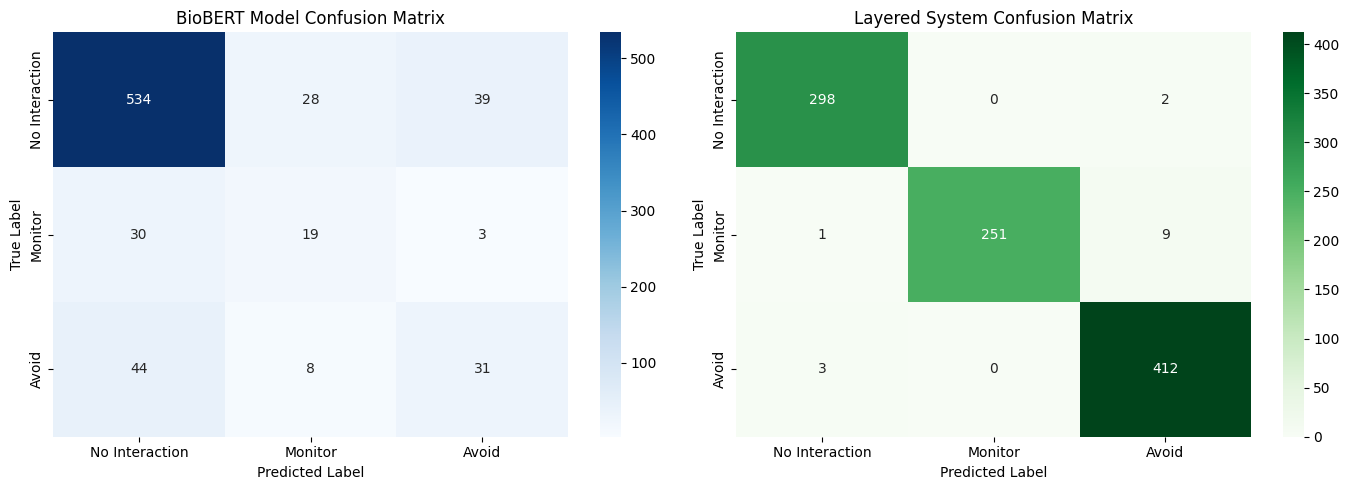

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm_model = cm        # model confusion matrix
cm_system = cm_sys   # system confusion matrix

labels = ["No Interaction", "Monitor", "Avoid"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(
    cm_model,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[0]
)
axes[0].set_title("BioBERT Model Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(
    cm_system,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[1]
)
axes[1].set_title("Layered System Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

df_eval = df_model.copy()

train_df, test_df = train_test_split(
    df_eval,
    test_size=0.2,
    stratify=df_eval["label"],
    random_state=42
)


In [ ]:
import torch
import numpy as np

y_true = []
y_pred = []

for _, row in test_df.iterrows():
    out = model_predict_action3(
        row["drugA_norm"],
        row["drugB_norm"]
    )
    pred_label = label2id[out["action_3class"]]

    y_true.append(row["label"])
    y_pred.append(pred_label)


In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
    recall_score,
    precision_score
)

cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="macro")
rec = recall_score(y_true, y_pred, average="macro")
prec = precision_score(y_true, y_pred, average="macro")

print("Confusion Matrix:\n", cm)
print("Accuracy:", acc)
print("Precision (macro):", prec)
print("Recall (macro):", rec)
print("F1-score (macro):", f1)

print("\nDetailed report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=["no_interaction", "monitor", "avoid"]
))


Confusion Matrix:
 [[534  28  39]
 [ 30  19   3]
 [ 44   8  31]]
Accuracy: 0.7934782608695652
Precision (macro): 0.549467184461777
Recall (macro): 0.542465908687868
F1-score (macro): 0.5453169247260293

Detailed report:

                precision    recall  f1-score   support

no_interaction       0.88      0.89      0.88       601
       monitor       0.35      0.37      0.36        52
         avoid       0.42      0.37      0.40        83

      accuracy                           0.79       736
     macro avg       0.55      0.54      0.55       736
  weighted avg       0.79      0.79      0.79       736



In [ ]:
!pip install -U langchain-community
!pip install fastapi uvicorn pyngrok -q


In [ ]:
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
from typing import Optional

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

class ChatRequest(BaseModel):
    message: str
    user_id: Optional[str] = None

@app.get("/")
def root():
    return {
        "status": "online",
        "model": "BioBERT DDI 3-class",
        "ready": True
    }

@app.post("/api/chat")
def chat(request: ChatRequest):
    try:
        # SİZİN ASK FONKSİYONUNUZ (zaten tanımlı)
        result = ask_en(request.message)

        # Sonuç formatına göre yanıt ver
        if isinstance(result, dict):
            # Eğer error varsa
            if "error" in result:
                return {"reply": result["error"]}

            # Eğer final_message_tr varsa (etkileşim sorgusu)
            if "final_message_tr" in result:
                return {"reply": result["final_message_tr"]}

            # Eğer usage sorgusu ise
            if "type" in result and result["type"] == "usage":
                return {"reply": result["text"]}

            # Diğer durumlar
            return {"reply": str(result)}

        # String ise direkt dön
        return {"reply": str(result)}

    except NameError as e:
        return {"reply": f"⚠️ Fonksiyon bulunamadı: {str(e)}. Lütfen önce model kodlarını çalıştırın."}

    except Exception as e:
        return {"reply": f"⚠️ Hata: {str(e)}"}

# ===== NGROK =====
from pyngrok import ngrok
import asyncio

ngrok.set_auth_token("36TRn8DA3V5QZbcvCqkOMKNdKcn_59VeMLiBHeY5GRditWnEk")

public_url = ngrok.connect(8000, bind_tls=True)
print("=" * 70)
print(f"🚀 Backend: {public_url.public_url}")
print(f"📋 .env.local'e ekle:")
print(f"NEXT_PUBLIC_API_URL={public_url.public_url}")
print("=" * 70)

async def main():
    import uvicorn
    config = uvicorn.Config(app, host="0.0.0.0", port=8000, log_level="info")
    server = uvicorn.Server(config)
    await server.serve()

await main()

ERROR:pyngrok.process.ngrok:t=2025-12-24T10:46:20+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nRun multiple endpoints at the same time from a single agent by defining them in your agent configuration file and running `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/agent/config/ \nYou can view your current agent sessions in the dashboard: https://dashboard.ngrok.com/agents. Upgrade to a paid plan to remove this limit:\nhttps://dashboard.ngrok.com/billing/choose-a-plan\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2025-12-24T10:46:20+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nRun multiple endpoints at the same time from a single agent by defining them in your agent configuration file and running `ngrok start --all`.\n

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nRun multiple endpoints at the same time from a single agent by defining them in your agent configuration file and running `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/agent/config/ \nYou can view your current agent sessions in the dashboard: https://dashboard.ngrok.com/agents. Upgrade to a paid plan to remove this limit:\nhttps://dashboard.ngrok.com/billing/choose-a-plan\r\n\r\nERR_NGROK_108\r\n.